In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch

from einops import rearrange
from functools import partial
from omegaconf import OmegaConf
from pathlib import Path

from lpdm.data import field_preprocess, get_well_dataset, isotropic_power_spectrum
from lpdm.nn.autoencoder import AutoEncoder

In [2]:
runpath = Path("/mnt/ceph/users/frozet/mpp-ldm/runs/euler_open_64x64x4_medium_adamw_1e-4_0_linear_1e0_97vb6co2")  # fmt: off
cfg = OmegaConf.load(runpath / "config.yaml")
device = "cuda"

## Data

In [3]:
testset = get_well_dataset(
    path=f"/mnt/ceph/users/polymathic/the_well/datasets/{cfg.dataset.physics}",
    split="test",
    steps=1,
    include_filters=cfg.dataset.include_filters,
)

preprocess = partial(
    field_preprocess,
    mean=torch.as_tensor(cfg.dataset.stats.mean, device=device),
    std=torch.as_tensor(cfg.dataset.stats.std, device=device),
    transform=cfg.dataset.transform,
)

In [4]:
field_names = [name for group in testset.metadata.field_names.values() for name in group]

## Autoencoder

In [5]:
autoencoder = AutoEncoder(
    pix_channels=testset.metadata.n_fields,
    **cfg.ae,
)

autoencoder.load_state_dict(torch.load(runpath / "state.pth"))
autoencoder.cuda()
autoencoder.eval()

AutoEncoder(
  (encoder): Encoder(
    (descent): ModuleList(
      (0): ModuleList(
        (0): Conv2d(5, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ResBlock(
          (block): Sequential(
            (0): GroupNorm(16, 64, eps=1e-05, affine=False)
            (1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (2): SiLU()
            (3): Identity()
            (4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          )
        )
      )
      (1): ModuleList(
        (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        (1-2): 2 x ResBlock(
          (block): Sequential(
            (0): GroupNorm(16, 128, eps=1e-05, affine=False)
            (1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (2): SiLU()
            (3): Identity()
            (4): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          )
        )
      )

In [6]:
sum(p.numel() for p in autoencoder.parameters())

58746633

## Evaluation

In [7]:
item = testset[69]
x = item["input_fields"]
x = x.to(device)
x = preprocess(x)
x = rearrange(x, "L H W C -> L C H W")

with torch.no_grad():
    z = autoencoder.encode(x)
    y = autoencoder.decode(z)

x = x.detach().cpu().squeeze(0)
z = z.detach().cpu().squeeze(0)
y = y.detach().cpu().squeeze(0)

In [8]:
error = (x - y).abs().reshape(testset.metadata.n_fields, -1)

In [9]:
error.mean(axis=-1)

tensor([0.0034, 0.0036, 0.0018, 0.0025, 0.0028])

In [10]:
error.median(axis=-1).values

tensor([0.0030, 0.0015, 0.0010, 0.0016, 0.0012])

In [11]:
error.max(axis=-1).values

tensor([0.5037, 0.3681, 0.1656, 0.2011, 0.3976])

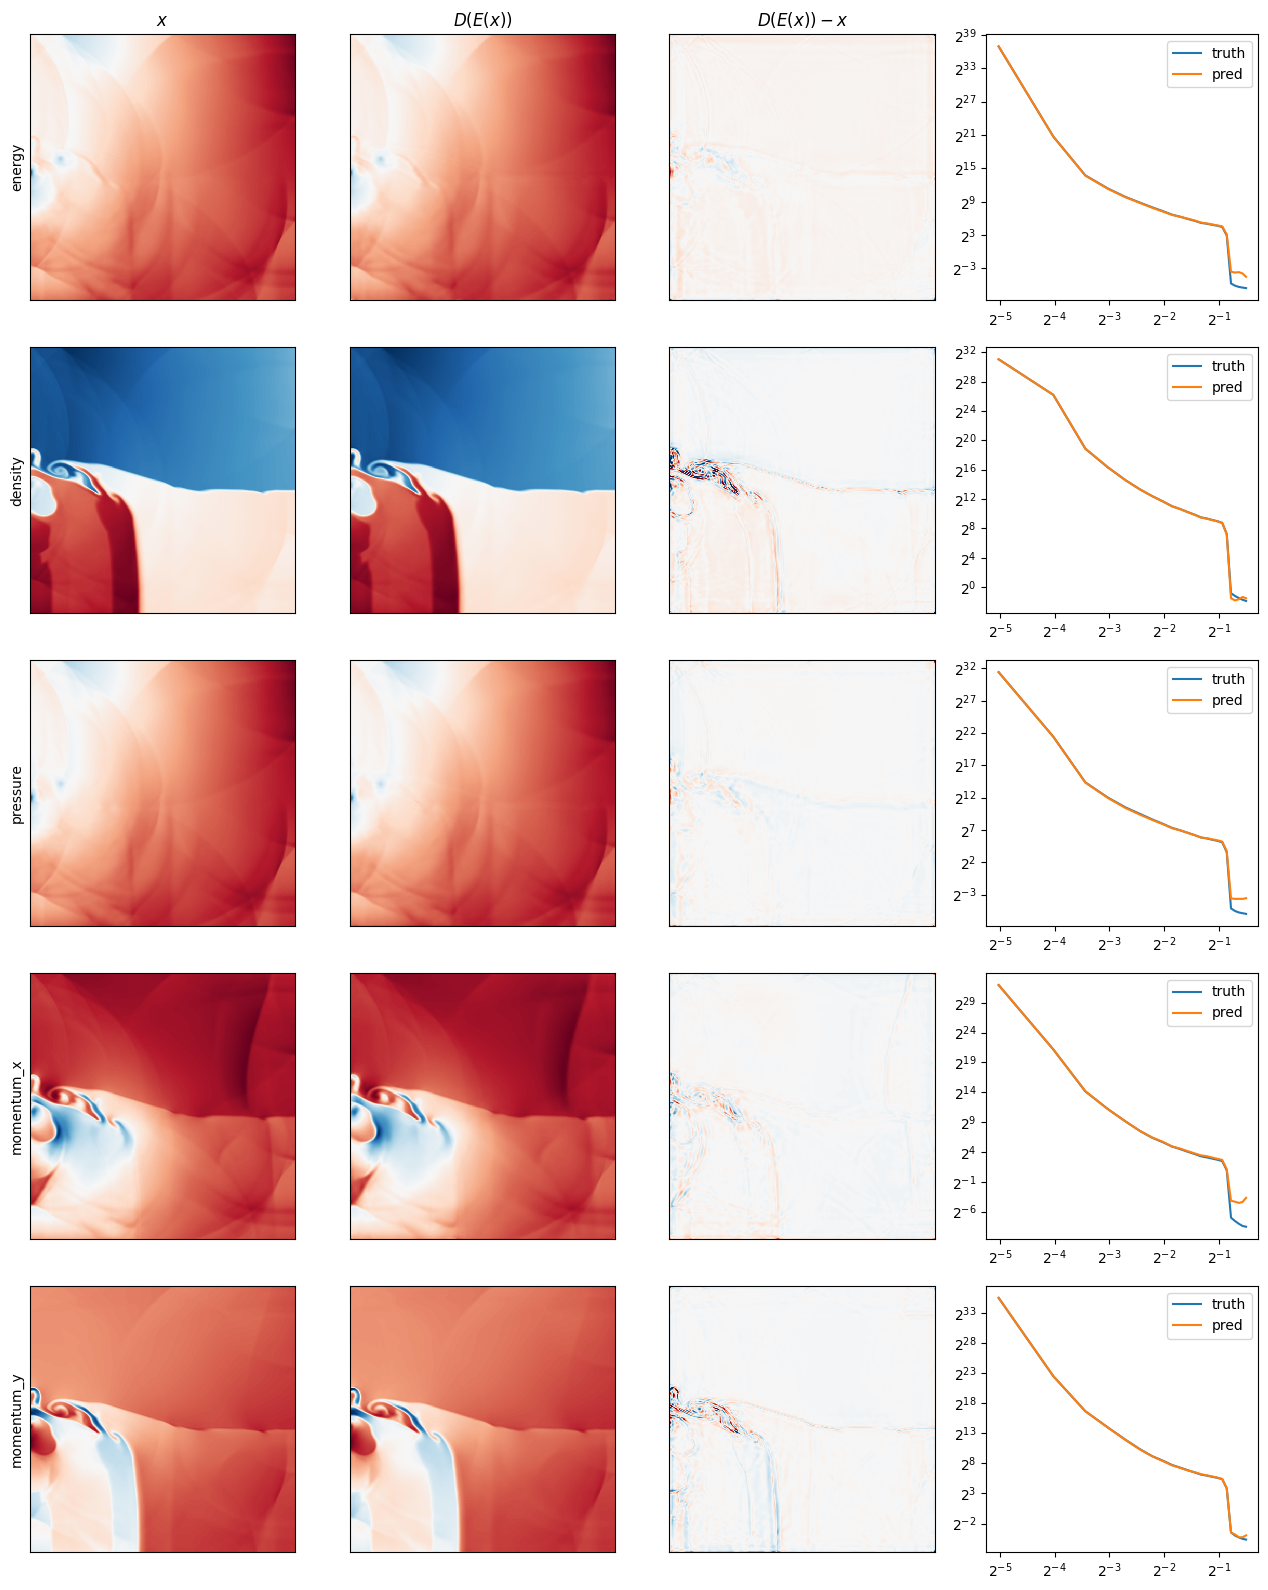

In [12]:
fig, axs = plt.subplots(
    nrows=testset.metadata.n_fields,
    ncols=4,
    figsize=(4 * 3.2, testset.metadata.n_fields * 3.2),
)

axs[0, 0].set_title("$x$")
axs[0, 1].set_title("$D(E(x))$")
axs[0, 2].set_title("$D(E(x)) - x$")

for field in range(testset.metadata.n_fields):
    vmin = np.nanmin(x[field])
    vmax = np.nanmax(x[field])

    axs[field, 0].set_ylabel(f"{field_names[field]}")

    axs[field, 0].imshow(x[field], cmap="RdBu_r", interpolation="none", vmin=vmin, vmax=vmax)
    axs[field, 0].set_xticks([])
    axs[field, 0].set_yticks([])

    axs[field, 1].imshow(y[field], cmap="RdBu_r", interpolation="none", vmin=vmin, vmax=vmax)
    axs[field, 1].set_xticks([])
    axs[field, 1].set_yticks([])

    axs[field, 2].imshow(
        y[field] - x[field], cmap="RdBu_r", interpolation="none", vmin=-0.1, vmax=0.1
    )
    axs[field, 2].set_xticks([])
    axs[field, 2].set_yticks([])

    x_ps, x_edges = isotropic_power_spectrum(x[field], spatial=2)
    y_ps, y_edges = isotropic_power_spectrum(y[field], spatial=2)

    axs[field, 3].loglog(x_edges[1:], x_ps, label="truth", base=2)
    axs[field, 3].loglog(y_edges[1:], y_ps, label="pred", base=2)
    axs[field, 3].legend()

plt.tight_layout()